In [61]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.integrate import solve_ivp
from scipy.sparse import lil_matrix
from qutip import Qobj, sesolve
import qutip as qt
from functools import partial
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
import os

In [ ]:
# region
#####################
# Utility Functions
#####################

J = 1 # satisfies initial condition h(0)/J = 1
# T_vals = np.linspace(0.05, 100, 300)
T_vals = [1, 10]
N_t = 20 # Number of time steps within T
I_star_final, I_star_final_driven = np.zeros(len(T_vals)), np.zeros(len(T_vals))

def control(t, T):
    """Transverse field h(t) = cos^2(pi * t/(2 * T))"""
    return np.cos((np.pi * t) / (2 * T))**2

def control_deriv(t, T):
    """h_dot (t) = -pi/(2T) * sin(pi * t/T)
        This is used to build the counterdiabatically driven Hamiltonian H_{CD}"""
    return (-np.pi / (2 * T)) * np.sin((np.pi * t) / T)

# region
def hamiltonian(t, T, J):
    """4x4 Hamiltonian matrix in the basis [uu, dd, ud, du]
        We are taking hbar = 1 for simplicity"""
    h = control(t, T)
    a, b, c = J/4, -J/4, h/2
    return np.array([
        [a, 0, c, c],
        [0, a, c, c],
        [c, c, b, 0],
        [c, c, 0, b]
    ], dtype=complex)

def K_matrix():
    """4x4 matrix corresponding to just the (S^x_1 + S^x_2) piece of the original Hamiltonian H(t),
        i.e. without the h(t) factor in, in the {uu, dd, ud, du} basis.
        This is used to build the counterdiabatically driven Hamiltonian H_{CD}.
        Remember we are taking hbar=1"""
    a = 1/2
    return np.array([
        [0, 0, a, a],
        [0, 0, a, a],
        [a, a, 0, 0],
        [a, a, 0, 0]
    ], dtype=complex)

K = K_matrix()

def gauge_potential(t, T, J):
    """Build the gauge potential term in the counterdiabatically driven Hamiltonian H_cd from the original undriven Hamiltonian,
            in the fixed [uu, dd, ud, du] basis.
        The Berry formula for the gauge potential piece is defined in terms of the instantaneous eigenbasis,
            so we need to transform between this and the [uu, dd, ud, du] basis."""
    
    # Diagonalise original Hamiltonian
    H_t = hamiltonian(t, T, J)
    values, vectors = np.linalg.eigh(H_t)   # values sorted ascending

    # Now build the new gauge potential piece
    U_dag = vectors.conj().T
    transformed_K = U_dag @ K @ vectors

    denom = values[None, :] - values[:, None]   # Matrix of energy differences: (m,n) -> E_n - E_m, shape (4, 4)
    nondegen_mask = np.abs(denom) > 1e-12
    offdiag_mask = (~np.eye(len(values), dtype=bool)) & nondegen_mask # mask out diagonal to avoid dividing by 0
    A_h = np.zeros_like(transformed_K, dtype=complex)
    A_h[offdiag_mask] = 1j * transformed_K[offdiag_mask] / denom[offdiag_mask] # Fill in off-diagonal entries only, leave diagonal zero (gauge choice)

    A_h_comp_basis = vectors @ A_h @ U_dag

    return A_h_comp_basis

def hamiltonian_cd(t, T, J):
    """Compose the full counterdiabatically driven Hamiltonian H_cd in the [uu, dd, ud, du] basis."""
    
    A_h = gauge_potential(t, T, J)
    H_t = hamiltonian(t, T, J)
    H_cd = H_t + control_deriv(t, T) * A_h

    return H_cd

def qt_hamiltonian(t, args):
    """Define the Hamiltonian using the qutip library.
        This will be useful to solve the Schroedinger equation later (using QuTip instead of solve_ivp)"""
    J = args['J']
    T = args['T']
    H_np = hamiltonian(t, T, J)
    return Qobj(H_np)

def qt_hamiltonian_cd(t, args):
    """Define the driven Hamiltonian using the qutip library.
        This will be useful to solve the Schroedinger equation later (using QuTip instead of solve_ivp)"""
    J = args['J']
    T = args['T']
    H_np = hamiltonian_cd(t, T, J)
    return Qobj(H_np)

# endregion

# ---- Redefine functions using permuted basis to match QuTip ----
def hamiltonian_permuted(t, T, J):
    """4x4 Hamiltonian matrix in the basis {uu, ud, du, dd}, so essentially a permutation
        of the above hamiltonian() function.
        Take hbar = 1 for simplicity again."""
    h = control(t, T)
    a, b, c = J/4, -J/4, h/2
    return np.array([
        [a, c, c, 0],
        [c, b, 0, c],
        [c, 0, b, c],
        [0, c, c, a]
    ], dtype=complex)

def K_matrix_permuted():
    """4x4 matrix corresponding to just the (S^x_1 + S^x_2) piece of the original Hamiltonian H(t),
        i.e. without the h(t) factor in, in the permuted {uu, ud, du, dd} basis.
        This is used to build the counterdiabatically driven Hamiltonian H_{CD}.
        Remember we are taking hbar=1"""
    a = 1/2
    return np.array([
        [0, a, a, 0],
        [a, 0, 0, a],
        [a, 0, 0, a],
        [0, a, a, 0]
    ], dtype=complex)

K_permuted = K_matrix_permuted()

def gauge_potential_permuted(t, T, J):
    """Build the gauge potential term in the counterdiabatically driven Hamiltonian H_cd from the original undriven Hamiltonian,
            in the permuted [uu, ud, du, dd] basis.
        The Berry formula for the gauge potential piece is defined in terms of the instantaneous eigenbasis,
            so we need to transform between this and the [uu, dd, ud, du] basis."""
    
    # Diagonalise original Hamiltonian
    H_t = hamiltonian_permuted(t, T, J)
    values, vectors = np.linalg.eigh(H_t)   # values sorted ascending

    # Now build the new gauge potential piece
    U_dag = vectors.conj().T
    transformed_K = U_dag @ K_permuted @ vectors

    denom = values[None, :] - values[:, None]   # Matrix of energy differences: (m,n) -> E_n - E_m, shape (4, 4)
    nondegen_mask = np.abs(denom) > 1e-12
    offdiag_mask = (~np.eye(len(values), dtype=bool)) & nondegen_mask # mask out diagonal to avoid dividing by 0
    A_h = np.zeros_like(transformed_K, dtype=complex)
    A_h[offdiag_mask] = 1j * transformed_K[offdiag_mask] / denom[offdiag_mask] # Fill in off-diagonal entries only, leave diagonal zero (gauge choice)

    A_h_comp_basis = vectors @ A_h @ U_dag

    return A_h_comp_basis

def hamiltonian_cd_permuted(t, T, J):
    """Compose the full counterdiabatically driven Hamiltonian H_cd in the [uu, dd, ud, du] basis."""
    
    A_h = gauge_potential_permuted(t, T, J)
    H_t = hamiltonian_permuted(t, T, J)
    H_cd = H_t + control_deriv(t, T) * A_h

    return H_cd

def qt_hamiltonian_permuted(t, args):
    """Define the Hamiltonian using the qutip library.
        This will be useful to solve the Schroedinger equation later (using QuTip instead of solve_ivp)"""
    J = args['J']
    T = args['T']
    H_np = hamiltonian_permuted(t, T, J)
    return Qobj(H_np)

def qt_hamiltonian_cd_permuted(t, args):
    """Define the driven Hamiltonian using the qutip library.
        This will be useful to solve the Schroedinger equation later (using QuTip instead of solve_ivp)"""
    J = args['J']
    T = args['T']
    H_np = hamiltonian_cd_permuted(t, T, J)
    return Qobj(H_np)

# endregion

# region
#####################
# Define Pauli-String Operator Basis
#####################

d = 4  # Hilbert space dimension for 2 qubits

# region
#####################
# Define 16D Operator Basis From Pauli String
#####################

# single-qubit basis: 0 = I, 1 = X, 2 = Y, 3 = Z
one_qubit = [qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()]
labels = ['I', 'X', 'Y', 'Z']

basis_ops = []
basis_labels = []
for i, Pi in enumerate(one_qubit):
    for j, Pj in enumerate(one_qubit):
        op = qt.tensor(Pi, Pj)       # σ_i ⊗ σ_j
        basis_ops.append(op)
        basis_labels.append(labels[i] + labels[j])  # "IX", "ZX", etc.

basis_dict = dict(zip(basis_labels, basis_ops))
print(basis_labels)
# print(basis_ops)
# endregion

# region
#####################
# Define Orthonormal 4D Operator Subspace
#####################

def hs_inner(A, B):
    """Normalised Hilbert-Schmidt inner product. Dividing by d ensures that under this inner product
        the Pauli string basis elements are orthonormal, i.e. have an inner product = 1."""
    return (A.dag() * B).tr() / d

def gram_matrix(basis):
    """Compute and print the Gram matrix of the 4D operator basis.
        Useful to check orthogonality/orthonormality.
        Gram matrix G_{ab} = <O_a, O_b>_HS"""

    G = np.zeros((4, 4), dtype=complex)
    for a in range(4):
        for b in range(4):
            G[a, b] = hs_inner(basis[a], basis[b])
    print("Gram matrix G:")
    print(G)

# Define unscaled basis
O1_raw = basis_dict['ZZ']
O2_raw = (basis_dict['IX'] + basis_dict['XI'])
O3_raw = basis_dict['YZ'] + basis_dict['ZY']
O4_raw = basis_dict['YY']

sub_basis = [O1_raw, O2_raw, O3_raw, O4_raw] # Orthogonal but not orthonormal basis
sub_norms = [hs_inner(op, op) for op in sub_basis]
print(sub_norms)

# Rescale to define orthonormal basis
for i in range(len(sub_basis)):
    sub_basis[i] = sub_basis[i] / np.sqrt(sub_norms[i])
O1, O2, O3, O4 = sub_basis
# print(sub_norms)
# print(sub_basis)

gram_matrix(sub_basis) # 4x4 identity matrix => orthonormal basis

def project(H):
    """Project any matrix H onto the 4D effective orthonormal operator basis we consider.
        Return the components of the 4D vector."""
    components = []
    for op in sub_basis:
        c = hs_inner(op, H)
        components.append(c)

    return components

def project_2D(H):
    """Project any matrix H to the 2D subspace spanned by operator basis elements O1, O2.
            Return the actual matrix, not the component vector in operator space.
            Use the orthogonal projection matrix with the Hilbert-Schmidt inner product as used above."""
    O1_comp = hs_inner(O1, H)
    O2_comp = hs_inner(O2, H)
    
    projection = O1_comp * O1 + O2_comp * O2
    return projection

def generator(H):
    """Build the generator of the Wegner-like flow as K_mu = i[P(H), H]."""
    projection = project_2D(H)
    return 1j*qt.commutator(projection, H)

# Define parameters for values of different commutators (structure constants) which will be useful when solving the PDE for coeffs
alpha_comm = project(qt.commutator(O1, O2))
alpha = alpha_comm[2]
beta_comm = project(qt.commutator(O1, O3))
beta = beta_comm[1]
gamma_comm = project(qt.commutator(O2, O3))
gamma = gamma_comm[0]
print(f'alpha = {alpha}')
print(f'beta = {beta}')
print(f'gamma = {gamma}')
print('\n')
# endregion

print(project(qt.commutator(O1, O3)))

# endregion

# region
############
# Functions to Solve Flow Equations
############

# ---- Utility Functions ----
def as_2qubit_qobj(M):
    """Wrap a 4x4 numpy matrix as a 2-qubit Qobj with tensor dims."""
    return qt.Qobj(M, dims=[[2,2],[2,2]])

def D1_4th_order(N, dt, neumann_endpoints=True):
    """
    1st-derivative matrix, 4th-order accurate interior.
    Uses 4th-order one-sided stencils near boundaries.
    If neumann_endpoints=True, force derivative at endpoints to 0 by zeroing first/last row.
    """
    D = np.zeros((N, N), dtype=float)

    # interior (central 4th order): f' = (-f_{i+2}+8f_{i+1}-8f_{i-1}+f_{i-2})/(12 dt)
    for i in range(2, N-2):
        D[i, i-2] =  1
        D[i, i-1] = -8
        D[i, i+1] =  8
        D[i, i+2] = -1
    D /= (12*dt)

    # 4th-order one-sided at i=0,1 and i=N-2,N-1
    # i=0: (-25 f0 + 48 f1 - 36 f2 + 16 f3 - 3 f4)/(12 dt)
    if N >= 5:
        D[0, 0:5] = np.array([-25, 48, -36, 16, -3])/(12*dt)
        # i=1: (-3 f0 -10 f1 + 18 f2 - 6 f3 + f4)/(12 dt)
        D[1, 0:5] = np.array([-3, -10, 18, -6, 1])/(12*dt)

        # mirrored at end
        D[N-2, N-5:N] = -np.array([-3, -10, 18, -6, 1])[::-1]/(12*dt)
        D[N-1, N-5:N] = -np.array([-25, 48, -36, 16, -3])[::-1]/(12*dt)
    else:
        raise ValueError("Need N>=5 for 4th-order boundary stencils.")

    if neumann_endpoints:
        D[0, :] = 0.0
        D[-1, :] = 0.0

    return D

# ---- Variational AGP in 4D Subspace ----
def K_permuted_qobj():
    """K = ∂H/∂h = (1/2)(IX+XI) in permuted basis, as a 2-qubit Qobj."""
    return as_2qubit_qobj(K_matrix_permuted())

Kq = K_permuted_qobj()

def variational_agp_4D(t, T, J, ridge=1e-12):
    """
    Returns Ah^(4D)(t) = sum_j a_j(t) O_j, with O_j from your orthonormal sub_basis.
    ridge: small Tikhonov regulariser to handle near-singular M (esp. near degeneracies).
    """
    H_np = hamiltonian_permuted(t, T, J)
    H = as_2qubit_qobj(H_np)

    # Build B_j = i[O_j, H]
    B = []
    for Oj in sub_basis:
        B.append(1j * qt.commutator(Oj, H))

    # Assemble M_ij = <B_i, B_j>, rhs_i = -<B_i, K>
    M = np.zeros((4, 4), dtype=complex)
    rhs = np.zeros(4, dtype=complex)

    for i in range(4):
        rhs[i] = -hs_inner(B[i], Kq)
        for j in range(4):
            M[i, j] = hs_inner(B[i], B[j])

    # Regularise (Hermitian part) to improve stability
    Mreg = 0.5*(M + M.conj().T) + ridge*np.eye(4)

    # Solve (least squares is robust if still ill-conditioned)
    a, *_ = np.linalg.lstsq(Mreg, rhs, rcond=None)

    # Construct Ah in 4D
    Ah = 0 * sub_basis[0]
    for j in range(4):
        Ah = Ah + a[j] * sub_basis[j]

    return Ah, a

def hamiltonian_cd_variational_4D(t, T, J, ridge=1e-12):
    H = as_2qubit_qobj(hamiltonian_permuted(t, T, J))
    Ah, _ = variational_agp_4D(t, T, J, ridge=ridge)
    Hcd = H + control_deriv(t, T) * Ah
    return Hcd

# ---- Method of Lines ----
# -------------------------

# ---- Initial conditions on a time grid ----
def initial_coeffs_from_Hcd(T, J, N_t=200, ridge=1e-10):
    t_grid = np.linspace(0.0, T, N_t, endpoint=True)
    c0 = np.zeros((4, N_t), dtype=complex)

    for k, t in enumerate(t_grid):
        H = as_2qubit_qobj(hamiltonian_permuted(t, T, J))

        # If hdot=0, CD term is zero, so skip AGP solve (also avoids degeneracy headaches)
        hdot = control_deriv(t, T)
        if abs(hdot) < 1e-12:
            Hcd = H
        else:
            Ah, _ = variational_agp_4D(t, T, J, ridge=ridge)
            Hcd = H + hdot * Ah

        c0[:, k] = np.array(project(Hcd), dtype=complex)

    return t_grid, c0

# ----Method of lines solver ----
def precompute_H_cd_coefficients(t_grid, T, J_const, 
                                 hamiltonian_cd_variational_4D, project):
    """
    Pre-compute H_cd(t) coefficients on the time grid.
    
    This is called ONCE before the ODE integration, avoiding expensive
    repeated calls to hamiltonian_cd_variational_4D() inside the RHS.
    
    Returns:
    --------
    H_cd_coeffs : ndarray, shape (4, N_t)
        Pre-computed coefficients [c1_cd(t), c2_cd(t), c3_cd(t), c4_cd(t)]
    """
    N_t = len(t_grid)
    H_cd_coeffs = np.zeros((4, N_t), dtype=complex)
    
    print(f"Pre-computing H_cd coefficients on {N_t} time points...")
    for k, t in enumerate(t_grid):
        H_cd = hamiltonian_cd_variational_4D(t, T, J_const)
        H_cd_coeffs[:, k] = np.array(project(H_cd))
        
        if (k + 1) % max(1, N_t // 10) == 0:
            print(f"  {k+1}/{N_t} points computed")
    
    print("Pre-computation complete!")
    return H_cd_coeffs

# def flow_rhs_mu(mu, y, N_t, t_grid, T, J_const, 
#                 hamiltonian_cd_variational_4D, project):
#     """
#     CORRECTED RHS for solve_ivp in μ.
    
#     Key fix: Time derivatives are computed from the protocol H_cd(t),
#     NOT from spatial derivatives of the solution.
#     """
    
#     c1 = y[0*N_t:1*N_t]
#     c2 = y[1*N_t:2*N_t]
#     c3 = y[2*N_t:3*N_t]
#     c4 = y[3*N_t:4*N_t]
    
#     # Compute time derivatives of products from the protocol
#     dt_a2a3 = np.zeros(N_t)
#     dt_a1a3 = np.zeros(N_t)
#     dt_a2a4 = np.zeros(N_t)
    
#     for k in range(N_t):
#         t_k = t_grid[k]
        
#         if k == 0:
#             # Forward difference at left boundary
#             t_next = t_grid[1]
#             H_cd_k = hamiltonian_cd_variational_4D(t_k, T, J_const)
#             H_cd_next = hamiltonian_cd_variational_4D(t_next, T, J_const)
#             c_k = np.array(project(H_cd_k))
#             c_next = np.array(project(H_cd_next))
#             dt = t_next - t_k
            
#             dt_a2a3[k] = (c_next[1]*c_next[2] - c_k[1]*c_k[2]) / dt
#             dt_a1a3[k] = (c_next[0]*c_next[2] - c_k[0]*c_k[2]) / dt
#             dt_a2a4[k] = (c_next[1]*c_next[3] - c_k[1]*c_k[3]) / dt
            
#         elif k == N_t - 1:
#             # Backward difference at right boundary
#             t_prev = t_grid[-2]
#             H_cd_prev = hamiltonian_cd_variational_4D(t_prev, T, J_const)
#             H_cd_k = hamiltonian_cd_variational_4D(t_k, T, J_const)
#             c_prev = np.array(project(H_cd_prev))
#             c_k = np.array(project(H_cd_k))
#             dt = t_k - t_prev
            
#             dt_a2a3[k] = (c_k[1]*c_k[2] - c_prev[1]*c_prev[2]) / dt
#             dt_a1a3[k] = (c_k[0]*c_k[2] - c_prev[0]*c_prev[2]) / dt
#             dt_a2a4[k] = (c_k[1]*c_k[3] - c_prev[1]*c_prev[3]) / dt
            
#         else:
#             # Central difference in the interior
#             t_prev = t_grid[k-1]
#             t_next = t_grid[k+1]
#             H_cd_prev = hamiltonian_cd_variational_4D(t_prev, T, J_const)
#             H_cd_next = hamiltonian_cd_variational_4D(t_next, T, J_const)
#             c_prev = np.array(project(H_cd_prev))
#             c_next = np.array(project(H_cd_next))
#             dt = t_next - t_prev
            
#             dt_a2a3[k] = (c_next[1]*c_next[2] - c_prev[1]*c_prev[2]) / dt
#             dt_a1a3[k] = (c_next[0]*c_next[2] - c_prev[0]*c_prev[2]) / dt
#             dt_a2a4[k] = (c_next[1]*c_next[3] - c_prev[1]*c_prev[3]) / dt
    
#     # Commutator parts (unchanged)
#     dc1_comm =  4.0*c1*(c3**2) + 4.0*(c2**2)*c4
#     dc2_comm =  4.0*c2*(-c1*c4 + 2.0*(c3**2) + (c4**2))
#     dc3_comm =  4.0*c3*(-(c1**2) + c1*c4 - 2.0*(c2**2))
#     dc4_comm = -4.0*c1*(c3**2) - 4.0*(c2**2)*c4
    
#     # Full μ-flow including ∂_t terms
#     dc1 = dc1_comm - 2.0 * dt_a2a3
#     dc2 = dc2_comm + 2.0 * dt_a1a3
#     dc3 = dc3_comm - 2.0 * dt_a2a4
#     dc4 = dc4_comm + 2.0 * dt_a2a3
    
#     return np.concatenate([dc1, dc2, dc3, dc4])

def flow_rhs_mu_new(mu, y, N_t, t_grid, T, J_const,
                    hamiltonian_cd_variational_4D, project):
    """
    RG flow RHS with K_μ = a₃O₃ + a₄O₄
    
    Flow equations:
        ∂_μ a₁ = -2a₂a₃
        ∂_μ a₂ = +2a₁a₃
        ∂_μ a₃ = -2a₂a₄ + ∂_t(a₃)
        ∂_μ a₄ = +2a₂a₃ + ∂_t(a₄)
    
    Returns:
    --------
    dydt : ndarray, shape (4*N_t,)
        Time derivatives of the stacked coefficients
    """
    
    # Unstack the coefficient arrays
    a1 = y[0*N_t:1*N_t]
    a2 = y[1*N_t:2*N_t]
    a3 = y[2*N_t:3*N_t]
    a4 = y[3*N_t:4*N_t]
    
    # ========================================================================
    # COMPUTE TIME DERIVATIVES OF a₃ AND a₄ FROM H_CD
    # ========================================================================
    
    a3_cd = np.zeros(N_t)
    a4_cd = np.zeros(N_t)
    
    for k in range(N_t):
        H_cd_k = hamiltonian_cd_variational_4D(t_grid[k], T, J_const)
        c_k = np.array(project(H_cd_k))
        a3_cd[k] = c_k[2]
        a4_cd[k] = c_k[3]
    
    # Compute time derivatives using finite differences
    dt_a3_cd = np.gradient(a3_cd, t_grid)
    dt_a4_cd = np.gradient(a4_cd, t_grid)
    
    # ========================================================================
    # COMPUTE FLOW EQUATIONS
    # ========================================================================
    
    # Commutator terms
    da1_comm = -2.0 * a2 * a3
    da2_comm = +2.0 * a1 * a3
    da3_comm = -2.0 * a2 * a4
    da4_comm = +2.0 * a2 * a3
    
    # Time derivative terms (only for a₃ and a₄)
    da1_time = np.zeros(N_t)
    da2_time = np.zeros(N_t)
    da3_time = dt_a3_cd
    da4_time = dt_a4_cd
    
    # Full flow equations
    da1 = da1_comm + da1_time
    da2 = da2_comm + da2_time
    da3 = da3_comm + da3_time
    da4 = da4_comm + da4_time
    
    return np.concatenate([da1, da2, da3, da4])

def make_early_stop_event(N_t, tol=1e-6, mode="max"):
    """
    Stop when off-subspace components (c3,c4) are small.
    mode="max": stop when max(|c3|,|c4|) - tol crosses 0.
    """
    def event(mu, y):
        c3 = y[2*N_t:3*N_t]
        c4 = y[3*N_t:4*N_t]
        if mode == "max":
            metric = max(np.max(np.abs(c3)), np.max(np.abs(c4)))
        else:
            metric = np.sqrt(np.mean(np.abs(c3)**2 + np.abs(c4)**2))
        return metric - tol
    event.terminal = True
    event.direction = -1
    return event

# def solve_flow_method_of_lines(T, J, N_t=200, mu_max=5.0,
#                                ridge_agp=1e-10,
#                                rtol=1e-7, atol=1e-9,
#                                stop_tol=1e-6):
#     """
#     CORRECTED full pipeline with proper time derivative computation.
#     """
    
#     # (1) Build initial condition
#     t_grid, c0 = initial_coeffs_from_Hcd(T, J, N_t=N_t, ridge=ridge_agp)
    
#     y0 = np.concatenate([c0[0], c0[1], c0[2], c0[3]])
    
#     # (2) Create RHS function with all required parameters
#     rhs_func = partial(
#         flow_rhs_mu,
#         N_t=N_t,
#         t_grid=t_grid,
#         T=T,
#         J_const=J,
#         hamiltonian_cd_variational_4D=hamiltonian_cd_variational_4D,
#         project=project
#     )
    
#     # (3) Integrate in μ
#     sol = solve_ivp(
#         fun=rhs_func,
#         t_span=(0.0, mu_max),
#         y0=y0,
#         method="RK45",           # Changed from BDF
#         rtol=rtol,
#         atol=atol,
#         max_step=0.1,            # Smaller max step
#         dense_output=True,
#     )
    
#     # (4) Extract final coefficients
#     y_end = sol.y[:, -1]
#     c1 = y_end[0*N_t:1*N_t]
#     c2 = y_end[1*N_t:2*N_t]
#     c3 = y_end[2*N_t:3*N_t]
#     c4 = y_end[3*N_t:4*N_t]
#     c_final = np.vstack([c1, c2, c3, c4])
    
#     return t_grid, sol, c_final

def solve_flow_method_of_lines_new(T, J, N_t=200, mu_max=5.0,
                                    ridge_agp=1e-12,
                                    rtol=1e-7, atol=1e-9,
                                    hamiltonian_cd_variational_4D=None,
                                    initial_coeffs_from_Hcd=None,
                                    project=None,
                                    make_early_stop_event=None):
    """
    Solve the RG flow using the new generator K_μ = a₃O₃ + a₄O₄
   
    Returns:
    --------
    t_grid : ndarray
        Time grid
    sol : ODE solution object
        Full solution from solve_ivp
    c_final : ndarray, shape (4, N_t)
        Final coefficient arrays
    """
    
    print("=" * 70)
    print("RG FLOW SOLVER WITH NEW GENERATOR K_μ = a₃O₃ + a₄O₄")
    print("=" * 70)
    
    # (1) Build initial condition
    print("\n[1/3] Building initial conditions...")
    t_grid, c0 = initial_coeffs_from_Hcd(T, J, N_t=N_t, ridge=ridge_agp)
    
    y0 = np.concatenate([c0[0], c0[1], c0[2], c0[3]])
    
    # (2) Create RHS function
    print("\n[2/3] Setting up ODE solver...")
    rhs_func = partial(
        flow_rhs_mu_new,
        N_t=N_t,
        t_grid=t_grid,
        T=T,
        J_const=J,
        hamiltonian_cd_variational_4D=hamiltonian_cd_variational_4D,
        project=project
    )
    
    # (3) Integrate in μ
    print(f"\n[3/3] Integrating RG flow (μ: 0 → {mu_max})...")
    sol = solve_ivp(
        fun=rhs_func,
        t_span=(0.0, mu_max),
        y0=y0,
        method="RK45",
        rtol=rtol,
        atol=atol,
        max_step=0.1,
        dense_output=True,
        events=make_early_stop_event(N_t, tol=1e-6) if make_early_stop_event else None,
    )
    
    print(f"Integration complete!")
    print(f"  Final μ: {sol.t[-1]:.4f}")
    print(f"  Status: {sol.status} (0=success, 1=event)")
    
    # (4) Extract final coefficients
    y_end = sol.y[:, -1]
    a1 = y_end[0*N_t:1*N_t]
    a2 = y_end[1*N_t:2*N_t]
    a3 = y_end[2*N_t:3*N_t]
    a4 = y_end[3*N_t:4*N_t]
    c_final = np.vstack([a1, a2, a3, a4])
    
    return t_grid, sol, c_final

# ---- Extract couplings ----
def extract_J_g_FF_prefactors(c_final):
    """
    For H_FF(t) = (J(t)/4) ZZ + (g(t)/2)(IX+XI).
    c_final shape (4, N_t) in basis O1=ZZ, O2=(IX+XI)/sqrt(2), ...
    """
    c1 = c_final[0]
    c2 = c_final[1]
    J_t = 4.0 * c1
    g_t = np.sqrt(2.0) * c2
    return J_t, g_t

# def everything(T, J, N_t, mu_max, plot=False):
#     """Put all the pieces together in a single function."""

#     t_grid, sol, c_final = solve_flow_method_of_lines(
#         T=T, J=J, N_t=N_t, mu_max=mu_max,
#         ridge_agp=1e-10,
#         rtol=1e-7, atol=1e-9,
#         stop_tol=1e-6
#     )
    
#     print("μ end:", sol.t[-1], "terminated early?", sol.status == 1)

#     # Extract and smooth J(t), g(t)
#     J_t_raw, g_t_raw = extract_J_g_FF_prefactors(c_final)
    
#     # Apply smoothing to remove numerical noise
#     from scipy.signal import savgol_filter
#     N = len(J_t_raw)
#     window = min(21, N if N % 2 == 1 else N-1)
#     window = max(window, 5)
    
#     if N >= window:
#         J_t = savgol_filter(np.real(J_t_raw), window_length=window, polyorder=3)
#         g_t = savgol_filter(np.real(g_t_raw), window_length=window, polyorder=3)
#     else:
#         J_t = np.real(J_t_raw)
#         g_t = np.real(g_t_raw)
    
#     # ... rest of plotting code
    
#     return t_grid, sol, c_final, J_t, g_t

def everything_new(T, J, N_t, mu_max, plot=False,
                   hamiltonian_cd_variational_4D=None,
                   initial_coeffs_from_Hcd=None,
                   project=None,
                   make_early_stop_event=None):
    """
    Put all the pieces together using the NEW solver with K_μ = a₃O₃ + a₄O₄
    
    Returns:
    --------
    t_grid : ndarray
        Time grid
    sol : ODE solution object
        Full solution from solve_ivp
    c_final : ndarray, shape (4, N_t)
        Final coefficient arrays
    J_t : ndarray
        Extracted and smoothed J(t)
    g_t : ndarray
        Extracted and smoothed g(t)
    """
    
    t_grid, sol, c_final = solve_flow_method_of_lines_new(
        T=T, J=J, N_t=N_t, mu_max=mu_max,
        ridge_agp=1e-10,
        rtol=1e-7, atol=1e-9,
        hamiltonian_cd_variational_4D=hamiltonian_cd_variational_4D,
        initial_coeffs_from_Hcd=initial_coeffs_from_Hcd,
        project=project,
        make_early_stop_event=make_early_stop_event
    )
    
    # Sanity checks
    a3_end = c_final[2]
    a4_end = c_final[3]
    print(f"\nFinal off-subspace components:")
    print(f"  max |a₃|: {np.max(np.abs(a3_end)):.2e}")
    print(f"  max |a₄|: {np.max(np.abs(a4_end)):.2e}")
    
    # Extract J(t) and g(t)
    a1 = np.real(c_final[0])
    a2 = np.real(c_final[1])
    
    J_t_raw = 4.0 * a1
    g_t_raw = np.sqrt(2.0) * a2
    
    # Apply smoothing
    N = len(J_t_raw)
    window = min(21, N if N % 2 == 1 else N - 1)
    window = max(window, 5)
    
    if N >= window:
        J_t = savgol_filter(J_t_raw, window_length=window, polyorder=3)
        g_t = savgol_filter(g_t_raw, window_length=window, polyorder=3)
    else:
        J_t = J_t_raw
        g_t = g_t_raw
    
    if plot:
        import matplotlib.pyplot as plt
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.5, 10))
        
        ax1.plot(t_grid, J_t, label='$J(t)_{\mu \mapsto \infty}$')
        ax1.axhline(J, linestyle='--', label=f'J = {J}')
        ax1.set_xlim(0,)
        ax1.set_xlabel('Time t')
        ax1.set_ylabel('J(t)')
        ax1.legend()
        ax1.grid(True, alpha=0.1)
        
        ax2.plot(t_grid, g_t, label='$g(t)_{\mu \mapsto \infty}$')
        ax2.set_xlim(0,)
        ax2.set_xlabel('Time t')
        ax2.set_ylabel('g(t)')
        ax2.legend()
        ax2.grid(True, alpha=0.1)
        
        plt.tight_layout()
        plt.show()
    
    return t_grid, sol, c_final, J_t, g_t

# endregion

# region
############
# Functions to Validate Flow Equation Solutions
############

# Target state in permuted basis {uu, ud, du, dd}:
psi_star_perm = np.array([0, 1/np.sqrt(2), 1/np.sqrt(2), 0], dtype=complex)

def make_interp(t_grid, y, kind="cubic", smooth=False):
    """
    Build interpolator y(t). Optionally smooth y first to remove grid-scale noise.
    """
    y_real = np.real(y)

    if smooth:
        # pick an odd window length <= len(y_real)
        w = min(len(y_real)//2*2-1, 31)
        if w >= 7:
            y_real = savgol_filter(y_real, window_length=w, polyorder=3)

    return interp1d(
        t_grid,
        y_real,
        kind=kind,
        bounds_error=False,
        fill_value=(y_real[0], y_real[-1])
    )

def hamiltonian_FF_permuted_matrix(t, J_of_t, g_of_t):
    """
    4x4 matrix in {uu, ud, du, dd} basis for
    H_FF(t) = (J(t)/4) ZZ + (g(t)/2)(IX+XI)
    (Pauli-string convention consistent with your 'second convention').
    """
    Jt = float(J_of_t(t))
    gt = float(g_of_t(t))
    a = Jt/4
    b = -Jt/4
    c = gt/2
    return np.array([
        [a, c, c, 0],
        [c, b, 0, c],
        [c, 0, b, c],
        [0, c, c, a]
    ], dtype=complex)

def qt_hamiltonian_FF(t, args):
    J_of_t = args["J_of_t"]
    g_of_t = args["g_of_t"]
    H_np = hamiltonian_FF_permuted_matrix(t, J_of_t, g_of_t)
    return as_2qubit_qobj(H_np)

# --- Validation ----
def compute_infidelities_FF_from_arrays(
    T, J_const, t_grid_flow, J_flow, g_flow,
    N_t=400,
    interp_kind="cubic",
    smooth_interp=False
):
    """Validate extracted J(t), g(t) by simulating evolution under H_FF and computing I(t), I*(t)."""
    # interpolators for J(t), g(t) defined on [0,T]
    J_of_t = make_interp(t_grid_flow, J_flow, kind=interp_kind, smooth=smooth_interp)
    g_of_t = make_interp(t_grid_flow, g_flow, kind=interp_kind, smooth=smooth_interp)

    # time grid for Schrödinger solve
    t_vals = np.linspace(0.0, T, N_t)

    # --- instantaneous ground states of the ORIGINAL Hamiltonian H(t) ---
    e_vecs = np.zeros((N_t, 4, 4), dtype=complex)
    for i, t in enumerate(t_vals):
        Ht = hamiltonian_permuted(t, T, J_const) 
        vals, vecs = np.linalg.eigh(Ht)
        e_vecs[i, :, :] = vecs

    ground_states = e_vecs[:, :, 0]   # (N_t,4)
    psi_init = ground_states[0]       # start in ground state of original H(0)

    # --- evolve under FF Hamiltonian ---
    psi0 = Qobj(psi_init, dims=[[2,2],[1,1]])
    args = {"J_of_t": J_of_t, "g_of_t": g_of_t}
    result = sesolve(qt_hamiltonian_FF, psi0, t_vals, e_ops=[], args=args)
    psi_t = np.vstack([st.full().ravel() for st in result.states])  # (N_t,4)

    # --- compute infidelities ---
    I = np.zeros(N_t)
    I_star = np.zeros(N_t)
    for i in range(N_t):
        I[i] = 1 - np.abs(np.vdot(ground_states[i], psi_t[i]))**2
        I_star[i] = 1 - np.abs(np.vdot(psi_star_perm, psi_t[i]))**2
    I[-1] = 1- np.abs(np.vdot(psi_star_perm, psi_t[i]))**2

    return t_vals, I, I_star, float(I_star[-1])

# infidelity function from part a for comparison
def compute_infidelities(T, N_t):
    t_vals = np.linspace(0, T, N_t)

    # region
    #####################
    # Diagonalise Hamiltonian to Find Instantaneous Ground States
    #####################

    # storage: eigenvalues [N_t, 4], eigenvectors [N_t, 4, 4]
    e_vals = np.zeros((N_t, 4), dtype=float)
    e_vecs = np.zeros((N_t, 4, 4), dtype=complex)

    for i, t in enumerate(t_vals):
        H_t = hamiltonian_permuted(t, T, J)
        values, vectors = np.linalg.eigh(H_t)   # values sorted ascending
        e_vals[i, :] = values
        e_vecs[i, :, :] = vectors             # columns are eigenvectors

    ground_energies = e_vals[:, 0]        # shape (N_t,)
    ground_states  = e_vecs[:, :, 0]      # shape (N_t, 4)

    # Target state in permuted basis {uu, ud, du, dd}:
    psi_star = np.array([0, 1/np.sqrt(2), 1/np.sqrt(2), 0], dtype=complex)
    psi_init = ground_states[0]
    # endregion

    #region
    #####################
    # Solve Time-Dependent Schroedinger Eqn
    #####################

    psi0 = Qobj(psi_init)  # initial condition as Qobj ket
    args = {'J': J, 'T': T}

    result = sesolve(qt_hamiltonian_permuted, psi0, t_vals, e_ops=[], args=args)
    psi_t_list = result.states                     # list of length N_t
    psi_t = np.vstack([psi.full().ravel() for psi in psi_t_list])  # (N_t, 4)

    # endregion

    #region
    #####################
    # Calculate Infidelities
    #####################

    I  = np.zeros(N_t)
    I_star = np.zeros(N_t)

    for i in range(N_t):
        I[i]      = 1 - np.abs(np.vdot(ground_states[i], psi_t[i]))**2
        I_star[i] = 1 - np.abs(np.vdot(psi_star, psi_t[i]))**2
    I[-1] = 1 - np.abs(np.vdot(psi_star, psi_t[i]))**2
    # endregion

    return t_vals, I, I_star, I_star[-1], I[-1]

def compute_infidelities_both(T, N_t):
    t_vals = np.linspace(0, T, N_t)

    # region
    #####################
    # Diagonalise Original Hamiltonian
    #####################

    # storage: eigenvalues [N_t, 4], eigenvectors [N_t, 4, 4]
    e_vals = np.zeros((N_t, 4), dtype=float)
    e_vecs = np.zeros((N_t, 4, 4), dtype=complex)

    for i, t in enumerate(t_vals):
        H_t = hamiltonian_permuted(t, T, J)
        values, vectors = np.linalg.eigh(H_t)   # values sorted ascending
        e_vals[i, :] = values
        e_vecs[i, :, :] = vectors             # columns are eigenvectors

    # Store the instantaneous ground states of the original Hamiltonian
    ground_energies = e_vals[:, 0]        # shape (N_t,)
    ground_states  = e_vecs[:, :, 0]      # shape (N_t, 4)

    psi_init = ground_states[0]

    # Target state in permuted basis {uu, ud, du, dd}:
    psi_star = np.array([0, 1/np.sqrt(2), 1/np.sqrt(2), 0], dtype=complex)

    # endregion

    #region
    #####################
    # Solve Time-Dependent Schroedinger Eqn (for both hamiltonians)
    #####################

    # ---- Now using QuTip instead ----
    psi0 = Qobj(psi_init)  # initial condition as Qobj ket
    args = {'J': J, 'T': T}

    sol = sesolve(qt_hamiltonian_permuted, psi0, t_vals, e_ops=[], args=args)
    psi_t_original_list = sol.states                     # list of length N_t
    psi_t_original = np.vstack([psi.full().ravel() for psi in psi_t_original_list])  # (N_t, 4)

    sol_cd = sesolve(qt_hamiltonian_cd_permuted, psi0, t_vals, e_ops=[], args=args)
    psi_t_driven_list = sol_cd.states
    psi_t_driven = np.vstack([psi.full().ravel() for psi in psi_t_driven_list])
    # endregion

    #region
    #####################
    # Calculate Infidelities
    #####################

    I  = np.zeros(N_t)
    I_star = np.zeros(N_t) # original infidelities
    I_driven  = np.zeros(N_t)
    I_star_driven = np.zeros(N_t) # driven infidelities

    for i in range(N_t):
        I[i]      = 1 - np.abs(np.vdot(ground_states[i], psi_t_original[i]))**2
        I_star[i] = 1 - np.abs(np.vdot(psi_star, psi_t_original[i]))**2
        I_driven[i]      = 1 - np.abs(np.vdot(ground_states[i], psi_t_driven[i]))**2
        I_star_driven[i] = 1 - np.abs(np.vdot(psi_star, psi_t_driven[i]))**2
    
    I[-1] = 1 - np.abs(np.vdot(psi_star, psi_t_original[i]))**2
    I_driven[-1] = 1 - np.abs(np.vdot(psi_star, psi_t_driven[i]))**2
    # endregion

    return t_vals, I, I_star, I_driven, I_star_driven

# endregion



['II', 'IX', 'IY', 'IZ', 'XI', 'XX', 'XY', 'XZ', 'YI', 'YX', 'YY', 'YZ', 'ZI', 'ZX', 'ZY', 'ZZ']
[1.0, 2.0, 2.0, 1.0]
Gram matrix G:
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]
alpha = 1.9999999999999996j
beta = -1.9999999999999996j
gamma = 1.9999999999999996j


[0.0, -1.9999999999999996j, 0.0, 0.0]


RG FLOW SOLVER WITH NEW GENERATOR K_μ = a₃O₃ + a₄O₄

[1/3] Building initial conditions...

[2/3] Setting up ODE solver...

[3/3] Integrating RG flow (μ: 0 → 20.0)...


C:\Users\cassi\AppData\Local\Temp\ipykernel_4672\244826501.py:658: ComplexWarning: Casting complex values to real discards the imaginary part
  a3_cd[k] = c_k[2]
C:\Users\cassi\AppData\Local\Temp\ipykernel_4672\244826501.py:659: ComplexWarning: Casting complex values to real discards the imaginary part
  a4_cd[k] = c_k[3]


Integration complete!
  Final μ: 20.0000
  Status: 0 (0=success, 1=event)

Final off-subspace components:
  max |a₃|: 2.39e-01
  max |a₄|: 2.22e-01


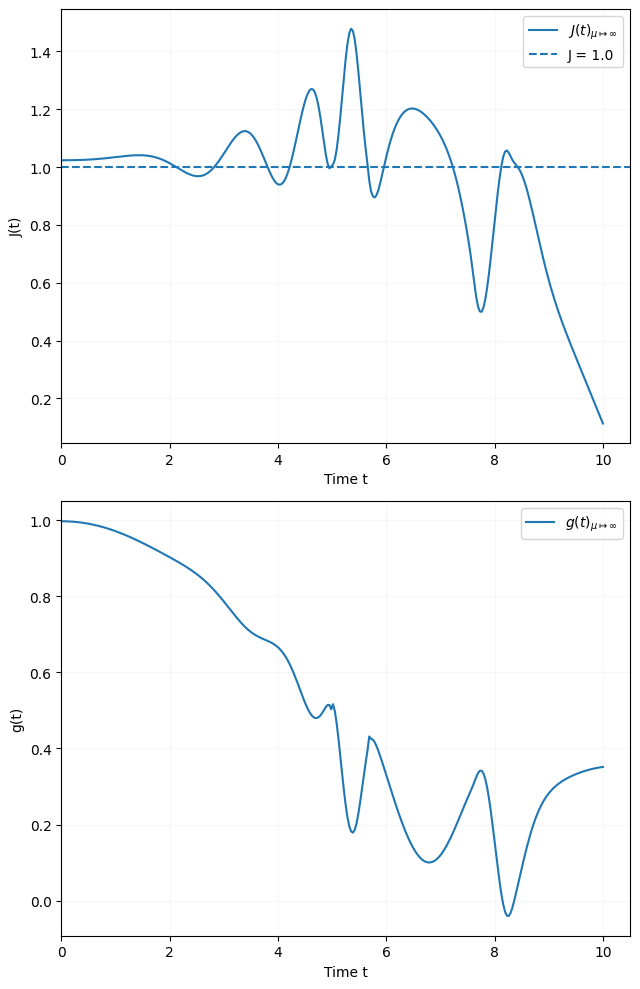

Final max|c3|: 2.39e-01
Final max|c4|: 2.22e-01
Solution status: 0 (0=success, 1=event)
Final target infidelity under FF: 0.06381437308331284


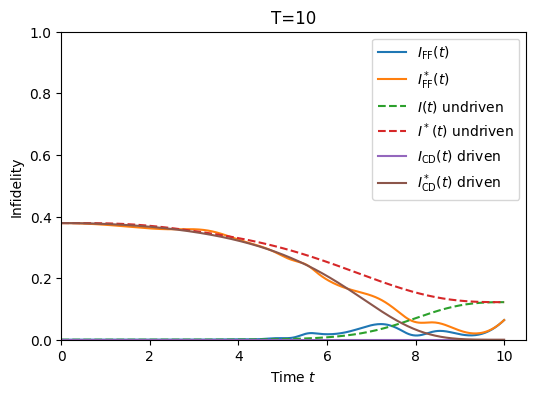

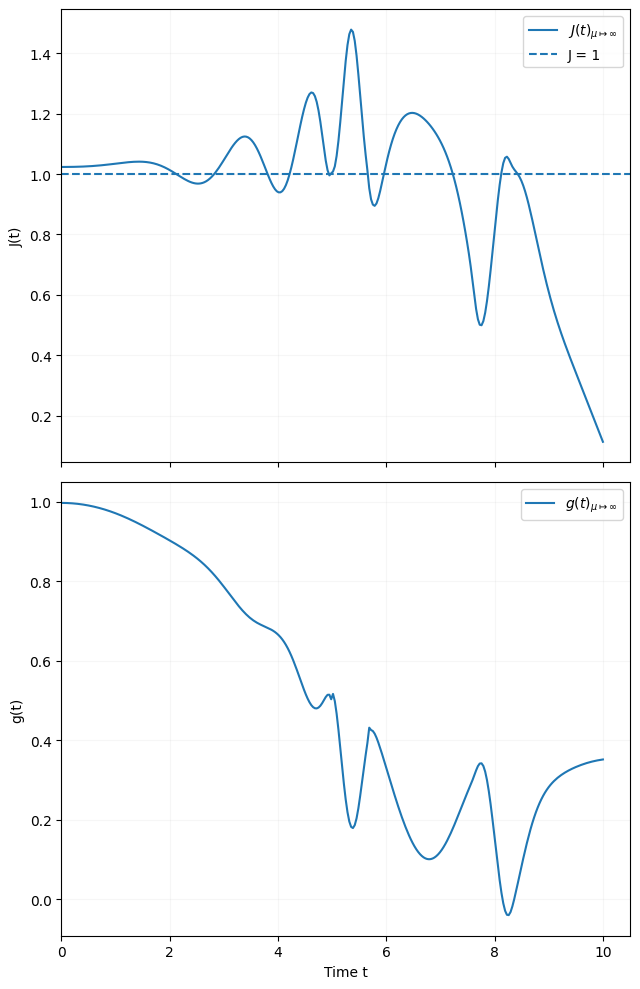

In [ ]:
T = 10.0
J_const = 1.0
N_t = 300  # Increased for better resolution
mu_max = 20.0  # Start smaller to test stability

# for original, slow
# t_grid, sol, c_final, J_flow, g_flow = everything(T, J_const, N_t, mu_max, plot=True)

# for original, fast
# t_grid, sol, c_final, J_flow, g_flow = everything_fast(
#       T, J_const, N_t, mu_max, plot=True,
#       hamiltonian_cd_variational_4D=hamiltonian_cd_variational_4D,
#       initial_coeffs_from_Hcd=initial_coeffs_from_Hcd,
#       project=project,
#       make_early_stop_event=make_early_stop_event
#   )

# for new generator
t_grid, sol, c_final, J_flow, g_flow = everything_new(
        T, J_const, N_t, mu_max, plot=True,
        hamiltonian_cd_variational_4D=hamiltonian_cd_variational_4D,
        initial_coeffs_from_Hcd=initial_coeffs_from_Hcd,
        project=project,
        make_early_stop_event=make_early_stop_event
    )

# Check convergence
c3_final = c_final[2]
c4_final = c_final[3]
print(f"Final max|c3|: {np.max(np.abs(c3_final)):.2e}")
print(f"Final max|c4|: {np.max(np.abs(c4_final)):.2e}")
print(f"Solution status: {sol.status} (0=success, 1=event)")

# FF validation
t_vals, I_FF, Istar_FF, Istar_FF_T = compute_infidelities_FF_from_arrays(
    T=T, J_const=J_const,
    t_grid_flow=t_grid, J_flow=J_flow, g_flow=g_flow,
    N_t=400,
    interp_kind="linear",
    smooth_interp=False  # try True first, given your noisy g(t)
)

print("Final target infidelity under FF:", Istar_FF_T)

# Undriven and counterdriven baseline from Parts A and B, using permuted basis
t_base, I_base_undriven, Istar_base_undriven, I_base_driven, Istar_base_driven = compute_infidelities_both(T, 400)
# endregion




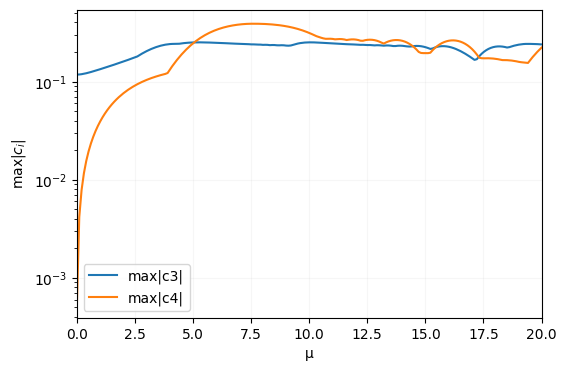

c3: 1.176e-01 → 2.387e-01
c4: 0.000e+00 → 2.216e-01

Generator coefficients at t=5:
  k1=0.031416+0.000000j, k2=-0.022214+0.000000j
  k3=-0.000000+0.000000j, k4=-0.031416+0.000000j


In [ ]:
def debug_initial_conditions(T, J, N_t=200, ridge=1e-10):
    t_grid, c0 = initial_coeffs_from_Hcd(T, J, N_t=N_t, ridge=ridge)
    J0 = 4*np.real(c0[0])
    g0 = np.sqrt(2)*np.real(c0[1])
    c3_0 = np.max(np.abs(c0[2]))
    c4_0 = np.max(np.abs(c0[3]))
    print("IC: max|c3| =", c3_0, " max|c4| =", c4_0)
    print("IC: J0 min/max =", J0.min(), J0.max())
    print("IC: g0 min/max =", g0.min(), g0.max())

    plt.figure(); plt.plot(t_grid, J0); plt.title("Initial J(t) from H_CD^(4D)"); plt.xlabel("t"); plt.ylabel("J"); plt.show()
    plt.figure(); plt.plot(t_grid, g0); plt.title("Initial g(t) from H_CD^(4D)"); plt.xlabel("t"); plt.ylabel("g"); plt.show()

debug_initial_conditions(T=10.0, J=1.0, N_t=200, ridge=1e-10)

# Check 1: Plot the full convergence trajectory
c3_max_vs_mu = []
c4_max_vs_mu = []

for i in range(len(sol.t)):
    y = sol.y[:, i]
    N_t = len(t_grid)
    c3 = y[2*N_t:3*N_t]
    c4 = y[3*N_t:4*N_t]
    c3_max_vs_mu.append(np.max(np.abs(c3)))
    c4_max_vs_mu.append(np.max(np.abs(c4)))

print(f"c3: {c3_max_vs_mu[0]:.3e} → {c3_max_vs_mu[-1]:.3e}")
print(f"c4: {c4_max_vs_mu[0]:.3e} → {c4_max_vs_mu[-1]:.3e}")

# Check 2: Verify the generator is correct
# At t=5 (middle of protocol), check if K_μ is driving the right direction

H_cd = hamiltonian_cd_variational_4D(5.0, T=10.0, J=1.0)
P_H = project_2D(H_cd)
K_mu = 1j * qt.commutator(P_H, H_cd)

k_coeffs = np.array(project(K_mu))
print(f"\nGenerator coefficients at t=5:")
print(f"  k1={k_coeffs[0]:.6f}, k2={k_coeffs[1]:.6f}")
print(f"  k3={k_coeffs[2]:.6f}, k4={k_coeffs[3]:.6f}")

# The off-subspace components (k3, k4) should be non-zero




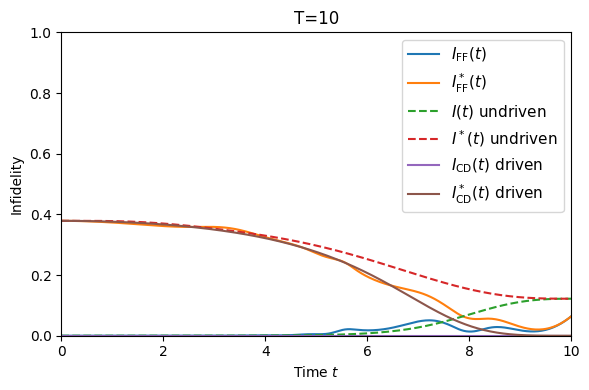

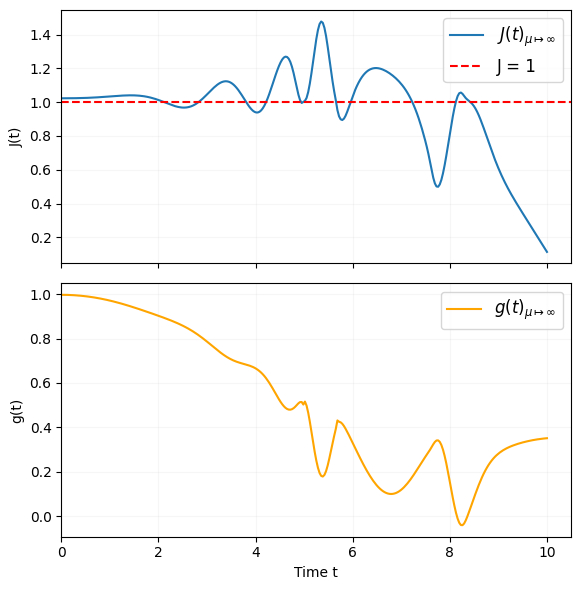

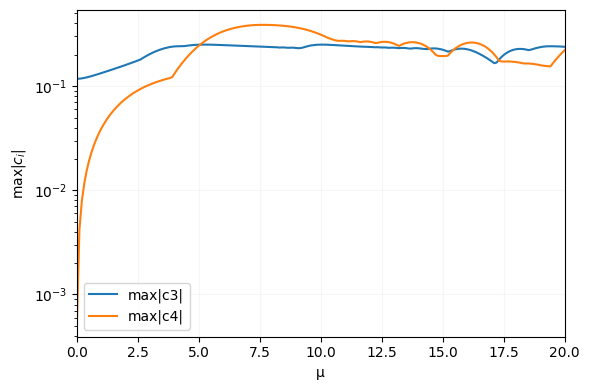

In [ ]:
# Plotting

OUTDIR = r"C:\Users\cassi\Documents\Cambridge\III\Project\Baptista\IMPRS-QDC Project\figures\part-c\new_gen"
os.makedirs(OUTDIR, exist_ok=True)

# ---- Plot Infidelities ----
fig1 = plt.figure(figsize=(6, 4))
plt.plot(t_vals, I_FF, label=r"$I_{\rm FF}(t)$")
plt.plot(t_vals, Istar_FF, label=r"$I^*_{\rm FF}(t)$")
plt.plot(t_base, I_base_undriven, "--", label=r"$I(t)$ undriven")
plt.plot(t_base, Istar_base_undriven, "--", label=r"$I^*(t)$ undriven")
plt.plot(t_base, I_base_driven, "-", label=r"$I_{\rm CD}(t)$ driven")
plt.plot(t_base, Istar_base_driven, "-", label=r"$I^*_{\rm CD}(t)$ driven")
plt.xlabel("Time $t$")
plt.ylabel("Infidelity")
plt.ylim(0, 1)
plt.xlim(0,10)
plt.legend(fontsize=11)
plt.title(f"T={T:g}")
fig1.tight_layout()
fig1.savefig(
    os.path.join(OUTDIR, "infidelities_t10.pdf"),
    format="pdf",
    bbox_inches="tight"
)
plt.show()
# endregion


# ---- Plot J(t), g(t) ----
fig2, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True)        
ax1.plot(t_grid, J_flow, label='$J(t)_{\mu \mapsto \infty}$')
ax1.axhline(J, linestyle='--', color='r', label=f'J = {J}')
ax1.set_xlim(0,)
# ax1.set_xlabel('Time t')
ax1.set_ylabel('J(t)')
# ax1.set_title('Extracted Coupling from μ-flow Fixed Point', fontsize=12)
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.1)

ax2.plot(t_grid, g_flow, color='orange', label='$g(t)_{\mu \mapsto \infty}$')
# ax2.set_xlim(0,)
ax2.set_xlabel('Time t')
ax2.set_ylabel('g(t)')
# ax2.set_title('Extracted Transverse Field from μ-flow Fixed Point', fontsize=12)
ax2.legend(fontsize=12)
ax2.grid(True, alpha=0.1)

fig2.tight_layout()
fig2.savefig(
    os.path.join(OUTDIR, "jg_extracted_subplots.pdf"),
    format="pdf",
    bbox_inches="tight"
)
plt.show()


# ---- Plot max(a3), max(a4) as a function of mu ----
fig3 = plt.figure(figsize=(6, 4))
plt.semilogy(sol.t, c3_max_vs_mu, label='max|c3|')
plt.semilogy(sol.t, c4_max_vs_mu, label='max|c4|')
plt.xlim(0,20)
plt.xlabel('μ')
plt.ylabel('max|$c_i$|')
# plt.title('Full Convergence Trajectory')
plt.legend()
plt.grid(True, alpha=0.1)
fig3.tight_layout()
fig3.savefig(
    os.path.join(OUTDIR, "diagnostics.pdf"),
    format="pdf",
    bbox_inches="tight"
)
plt.show()

## Other Checks

In [6]:
def as_2qubit_qobj(M):
    """Convert a 4x4 numpy matrix into a Qobj with 2-qubit tensor dims."""
    return qt.Qobj(M, dims=[[2, 2], [2, 2]])

#####################
# Helpers for 4D-subspace check
#####################

def reconstruct_from_components(comps):
    return sum(comps[i] * sub_basis[i] for i in range(4))

def hs_norm(A):
    return np.sqrt(np.real(hs_inner(A, A)))

def residual_outside_4D(A):
    if not isinstance(A, qt.Qobj):
        A = as_2qubit_qobj(A)
    comps = np.array(project(A), dtype=complex)
    A_proj = reconstruct_from_components(comps)
    R = A - A_proj
    return hs_norm(R)

def hermiticity_error(A):
    if not isinstance(A, qt.Qobj):
        A = as_2qubit_qobj(A)
    return hs_norm(A - A.dag())

#####################
# One-shot evaluation at a single time t
#####################

def demo_single_time(t=0.3, T=1.0, J=1.0):
    Ah_np = gauge_potential_permuted(t, T, J)   # numpy 4x4
    Ah = as_2qubit_qobj(Ah_np)

    comps = np.array(project(Ah), dtype=complex)
    print(f"t={t}, T={T}, J={J}")
    print("A_h 4D components [<O1|Ah>, <O2|Ah>, <O3|Ah>, <O4|Ah>]:")
    print(comps)
    print("Hermiticity error ||Ah - Ah^†||_HS:", hermiticity_error(Ah))
    print("Outside-4D residual ||Ah - P_4D(Ah)||_HS:", residual_outside_4D(Ah))

#####################
# Sweep over time grid and check "always in 4D"
#####################

def check_Ah_in_4D_over_time(T=1.0, J=1.0, n=200, tol=1e-10, skip_endpoint=True):
    ts = np.linspace(0.0, T, n, endpoint=not skip_endpoint)

    max_res = 0.0
    worst_t = None
    worst_comps = None

    for t in ts:
        Ah = as_2qubit_qobj(gauge_potential_permuted(t, T, J))
        res = residual_outside_4D(Ah)
        if res > max_res:
            max_res = res
            worst_t = t
            worst_comps = np.array(project(Ah), dtype=complex)

    print(f"Checked {len(ts)} times in [0, {T}] (skip_endpoint={skip_endpoint})")
    print("Max outside-4D residual:", max_res)
    print("Worst t:", worst_t)
    print("4D components at worst t:", worst_comps)
    print("Within tolerance?", max_res < tol)

#####################
# Example usage
#####################

J = 1.0
T = 10.0

demo_single_time(t=0.3*T, T=T, J=J)
check_Ah_in_4D_over_time(T=T, J=J, n=400, tol=1e-10, skip_endpoint=True)


t=3.0, T=10.0, J=1.0
A_h 4D components [<O1|Ah>, <O2|Ah>, <O3|Ah>, <O4|Ah>]:
[0.        -8.22123709e-19j 0.        -1.38777878e-17j
 0.12758769+0.00000000e+00j 0.        -9.12599767e-19j]
Hermiticity error ||Ah - Ah^†||_HS: 5.129119138482232e-17
Outside-4D residual ||Ah - P_4D(Ah)||_HS: 2.7855947011081818e-16
Checked 400 times in [0, 10.0] (skip_endpoint=True)
Max outside-4D residual: 0.014601939054702136
Worst t: 9.975000000000001
4D components at worst t: [0.        -1.46173958e-20j 0.        +0.00000000e+00j
 1.41421356+0.00000000e+00j 0.        +8.67361738e-19j]
Within tolerance? False
